# General

The job of this notebook is to:

* Load the preprocessed tracking data into a `master_df` DataFrame

* Add handcrafted features as columns to `master_df`

* Save the `master_df` so it can be used for later classification notebooks

## Style / naming guide / coding hints

* Axes in column labels such as 'X' and 'Y' are always capitalized: e.g. `left_ear_X`
* All coordinates are in cm, area in cm^2
* All angles are in degrees
* 0° is up / north in the video frame
* whenever extracting features, do sanity checks on them:
  * plot time course: are there weird discontinuities etc.?
* often, rounding values makes sense to reduce numerical errors (e.g. angles such as 34.999999° are biologically meaningless -> round to 35°

# Housekeeping

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches

# Loading the data from Google Drive

In [ ]:
#Because we are using a Shared with me drive, we need to have a small workaround
#In your shared with me folder, right click on:
#NMA_2022_Sfenj_Group_1"
#And click "Make a shortcut", and have this shortcut within your own drive

#now we can mount our drive
from pickle import load
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
#Since you have mounted your drive, which includes this shortcut, you can now access the files within that shortcut:
master_df = pd.read_csv('/content/drive/MyDrive/NMA_2022_Sfenj_Group_1/master_df.csv')

#test by showing the head
master_df.head()

## Conversion to cm 
The tracking data is provided in "pixel" units, to convert into Centimeters units, all coordinates need to be divided by 37.7

In [5]:
## converts dataframe into units of cm
## uses conversion of 37.7 pixels/cm
x = master_df.columns.tolist()
x= x[5:]
master_df[x]= master_df[x]/37.7

# Adding features

#### Postion centroids

Centroids are calculated by taking the mean of the individual coordinates.

In [6]:
#Now we can calculate features in the master_df
#re-create indexing variables from when master_df was initially created
master_dict = {'frame_num':[], 'session_num': [], 'mouse_id': [], 'annotations':[]}
pos_x_names = ['nose_X', 'left_ear_X', 'right_ear_X','neck_X', 'left_hip_X', 'right_hip_X', 'tailbase_X'] 
pos_y_names = ['nose_Y', 'left_ear_Y', 'right_ear_Y','neck_Y', 'left_hip_Y', 'right_hip_Y', 'tailbase_Y']

# get average of all XY positions for centroid location
#calcuate the mean of all x's and y's (centroid of all 7 pts)
master_df['centroid_X'] = master_df[pos_x_names].mean(axis=1) 
master_df['centroid_Y'] = master_df[pos_y_names].mean(axis=1)

master_df['centroid_head_X'] = master_df[['nose_X', 'left_ear_X', 'right_ear_X','neck_X']].mean(axis=1)
master_df['centroid_head_Y'] = master_df[['nose_Y', 'left_ear_Y', 'right_ear_Y','neck_Y']].mean(axis=1)
master_df['centroid_body_X'] = master_df[['left_hip_X', 'right_hip_X', 'tailbase_X']].mean(axis=1)
master_df['centroid_body_Y'] = master_df[['left_hip_Y', 'right_hip_Y', 'tailbase_Y']].mean(axis=1)

master_df.head()

,Unnamed: 0,frame_num,session_num,mouse_id,annotations,nose_X,nose_Y,left_ear_X,left_ear_Y,right_ear_X,...,right_hip_X,right_hip_Y,tailbase_X,tailbase_Y,centroid_X,centroid_Y,centroid_head_X,centroid_head_Y,centroid_body_X,centroid_body_Y
0,0,0,0,0,3,22.059926,5.382346,21.370271,6.655555,20.574515,...,18.876902,5.117094,17.073188,5.859799,19.934121,5.920428,21.177963,5.766961,18.275664,6.125051
1,1,1,0,0,1,22.096829,5.355307,21.460224,6.681567,20.637943,...,19.019906,5.116580,17.083566,6.044962,20.035442,6.010858,21.241391,5.819498,18.427509,6.266005
2,2,2,0,0,1,22.247188,4.770894,21.663633,6.495032,20.602625,...,18.931538,5.221822,17.154349,6.203254,20.125172,5.919056,21.351962,5.599806,18.489451,6.344722
3,3,3,0,0,1,21.929907,4.645837,21.638130,6.237349,20.550597,...,18.879509,5.255917,17.102321,6.290400,20.095879,5.809157,21.240252,5.408437,18.570049,6.343450
4,4,4,0,0,1,21.804926,4.627531,21.539674,5.900741,20.372565,...,18.807578,5.158035,17.136491,6.192518,20.027738,5.658225,21.095377,5.217717,18.604219,6.245569


## Unstable / Playground below

# speed and acceleration of the centroid of head, hips(body), and the whole body (centroid of all body parts). 
Speed is defined as distance of adjacent frames of the centroids. accelaration is the difference cross frames of the speed. speed and data are converted to cm/s and cm/s**2 using 30Hz as frame rate.

As we would like to maybe add smoothing filter to the speed data and the start and end of each session and each animal would be problematic for the filter operation on the whole master_df dict, here we use two for loops to work on individual animal and session to get speed. Currently, no smoothing filter is used yet.

In [7]:
# #### IMPROVEMENT ########
# use np.diff pre-pad function: 
# and use np.linarg.norm function 
# #################

# ############ Functions #######################
# define a helper function to calculate speed and normalize to frame rate
def speed_calc(x,y,framerate):
  speed = np.sqrt(x**2+y**2)*framerate
  return speed

# function to take in master_df, calculate 3 speed and 3 acceleration return to 3 variable
def get_features_speed_acc(master_df, framerate):
  # allocate empty varibles
  rec_spd_centr_head = []
  rec_spd_centr_hip = []
  rec_spd_centr_all = []
  rec_acc_centr_head = [] # cm/s^2
  rec_acc_centr_hip = []
  rec_acc_centr_all = []

  for ses in master_df['session_num'].unique():
    session =  master_df[master_df['session_num'] == ses]
  for ani in session['mouse_id'].unique():
    animal = session[session['mouse_id'] == ani]
    # head centroid
    x_diff = np.diff( animal['centroid_head_X'] )
    y_diff = np.diff( animal['centroid_head_Y'] )    
    tmp_X = np.hstack((np.nan,  x_diff) ).T
    tmp_Y = np.hstack((np.nan,  y_diff) ).T    
    tmp_spd = speed_calc(tmp_X,tmp_Y,framerate) # speed within a session an animal  
    rec_spd_centr_head = np.append(rec_spd_centr_head, tmp_spd)
    # accelaration: diff(speed)
    tmp_acc = ( np.hstack((np.nan, np.diff(tmp_spd))).T)/(1/framerate) # cm/s^2
    rec_acc_centr_head = np.append(rec_acc_centr_head, tmp_acc)

    # hip centroid
    x_diff = np.diff( animal['centroid_body_X'] )
    y_diff = np.diff( animal['centroid_body_Y'] )
    tmp_X = np.hstack((np.nan,  x_diff) ).T
    tmp_Y = np.hstack((np.nan,  y_diff) ).T    
    tmp_spd = speed_calc(tmp_X,tmp_Y,framerate)  
    rec_spd_centr_hip = np.append(rec_spd_centr_hip, tmp_spd)
    tmp_acc = (np.hstack((np.nan, np.diff(tmp_spd))).T)/(1/framerate)
    rec_acc_centr_hip = np.append(rec_acc_centr_hip, tmp_acc)

    # all parts centroid
    x_diff = np.diff( animal['centroid_X'] )
    y_diff = np.diff( animal['centroid_Y'] )
    tmp_X = np.hstack((np.nan,  x_diff) ).T
    tmp_Y = np.hstack((np.nan,  y_diff) ).T    
    tmp_spd = speed_calc(tmp_X,tmp_Y,framerate)  
    rec_spd_centr_all = np.append(rec_spd_centr_all, tmp_spd)
    tmp_acc = (np.hstack((np.nan, np.diff(tmp_spd))).T)/(1/framerate)
    rec_acc_centr_all = np.append(rec_acc_centr_all, tmp_acc)
  return   rec_spd_centr_head, rec_spd_centr_hip, rec_spd_centr_all, rec_acc_centr_head, rec_acc_centr_hip, rec_acc_centr_all

# ###############################################
# define frame rate 30Hz
frame_rate = 30 

# run the function
rec_spd_centr_head, rec_spd_centr_hip, rec_spd_centr_all, rec_acc_centr_head, rec_acc_centr_hip, rec_acc_centr_all = get_features_speed_acc(master_df, frame_rate)




# add speed and acceleration to master_df. 
# depending on what we want to do, we can append them after calculating all features. currently commented out
# # append centroid speeds (3 variables) to the master_df
# master_df['spd_head_centroid'] = rec_spd_centr_head
# master_df['spd_body_centroid'] = rec_spd_centr_hip
# master_df['spd_centroid'] = rec_spd_centr_all

# # append centroid speeds (3 variables) to the master_df
# master_df['acc_head_centroid'] = rec_acc_centr_head
# master_df['acc_body_centroid'] = rec_acc_centr_hip
# master_df['acc_centroid'] =      rec_acc_centr_all

### Area

In [ ]:
## calculation to get area of head, can use the same to get area of body, order of points matters when creating the polygon, order below needs to be fixed!!
from shapely.geometry import Polygon
poly_area_head =[]
for x in range(0,len(master_df['frame_num'])):
  poly = Polygon([(master_df.nose_X.iloc[x], master_df.nose_Y.iloc[x]), (master_df.left_ear_X.iloc[x], master_df.left_ear_Y.iloc[x]), (master_df.right_ear_X.iloc[x], master_df.right_ear_Y.iloc[x]),(master_df.neck_X.iloc[x], master_df.neck_Y.iloc[x])])
  poly_area_head.append(poly.area)
master_df["poly_area_head"] = poly_area_head

In [ ]:
master_df.head()

,Unnamed: 0,frame_num,session_num,mouse_id,annotations,nose_X,nose_Y,left_ear_X,left_ear_Y,right_ear_X,...,centroid_X,centroid_Y,head_centroid_x,head_centroid_y,body_centroid_x,body_centroid_y,body_centroid_X,body_centroid_Y,head_centroid_X,head_centroid_Y
0,0,0,0,0,3,831.659204,202.914433,805.659204,250.914433,775.659204,...,751.516347,223.200147,798.409204,217.414433,711.909204,229.664433,711.909204,229.664433,798.409204,217.414433
1,1,1,0,0,1,833.050439,201.895063,809.050439,251.895063,778.050439,...,755.336154,226.609349,800.800439,219.395063,716.800439,234.645063,716.800439,234.645063,800.800439,219.395063
2,2,2,0,0,1,838.718976,179.862692,816.718976,244.862692,776.718976,...,758.718976,223.148406,804.968976,211.112692,719.718976,235.862692,719.718976,235.862692,804.968976,211.112692
3,3,3,0,0,1,826.757507,175.148063,815.757507,235.148063,774.757507,...,757.614650,219.005206,800.757507,203.898063,721.507507,233.898063,721.507507,233.898063,800.757507,203.898063
4,4,4,0,0,1,822.045709,174.457936,812.045709,222.457936,768.045709,...,755.045709,213.315079,795.295709,196.707936,720.795709,229.457936,720.795709,229.457936,795.295709,196.707936


### Head angle

$cos(\alpha) = \frac{\bar{a}\cdot\bar{b}}{|a||b|}$ 

In [ ]:
# head angle calcullation
vec_neck_tailbase = np.array((master_df['neck_X'] - master_df['tailbase_X'], master_df['neck_Y'] - master_df['tailbase_Y'])).T
vec_nose_neck = np.array((master_df['nose_X'] - master_df['neck_X'], master_df['nose_Y'] - master_df['neck_Y'])).T
dummy1 = np.array(np.linalg.norm(vec_neck_tailbase, axis=1)*np.linalg.norm(vec_nose_neck, axis=1))
dummy2 = np.zeros(len(vec_neck_tailbase))
len(vec_neck_tailbase)
for i in range(len(vec_neck_tailbase)):
  dummy2[i] = np.dot(vec_neck_tailbase[i],vec_nose_neck[i])
angle_head_body = np.degrees(np.arccos(dummy2/dummy1))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':


In [ ]:
angle_head_body.shape

(996194,)

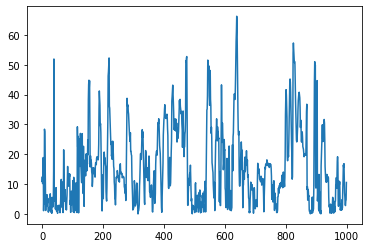

In [ ]:
plt.plot(angle_head_body[10000:11000])

In [ ]:
np.degrees(2*np.pi)

360.0

In [ ]:
tail_neck_vec_x = master_df['neck_X'] - master_df['tailbase_X']
tail_neck_vec_y = master_df['neck_Y'] - master_df['tailbase_Y']

neck_nose_vec_x = master_df['nose_X'] - master_df['neck_X']
neck_nose_vec_y = master_df['nose_Y'] - master_df['neck_Y']

In [ ]:
tail_neck_vec_y.describe()

count    996193.000000
mean          3.820024
std          79.079291
min        -253.000000
25%         -60.000000
50%           5.000000
75%          69.000000
max         247.000000
dtype: float64

In [ ]:
sp = (tail_neck_vec_x * neck_nose_vec_x) + (tail_neck_vec_y * neck_nose_vec_y)

In [ ]:
direction_cosines = sp / (np.sqrt(tail_neck_vec_x**2 + tail_neck_vec_y**2) * np.sqrt(neck_nose_vec_x**2 + neck_nose_vec_y**2))

In [ ]:
direction_cosines.describe()

count    996193.000000
mean          0.844296
std           0.260033
min          -1.000000
25%           0.816205
50%           0.942116
75%           0.988165
max           1.000000
dtype: float64

In [ ]:
head_angle = np.arccos(direction_cosines)*180/(np.pi)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
head_angle.describe()

count    996128.000000
mean         25.537555
std          23.367300
min           0.000000
25%           8.826063
50%          19.591011
75%          35.293369
max         180.000000
dtype: float64

In [ ]:
## 
tail_neck_vec_x = master_df['neck_X'] - master_df['tailbase_X']
tail_neck_vec_y = master_df['neck_Y'] - master_df['tailbase_Y']

neck_nose_vec_x = master_df['nose_X'] - master_df['neck_X']
neck_nose_vec_y = master_df['nose_Y'] - master_df['neck_Y']

sp = (tail_neck_vec_x * neck_nose_vec_x) + (tail_neck_vec_y * neck_nose_vec_y)
direction_cosines = sp / (np.sqrt(tail_neck_vec_x**2 + tail_neck_vec_y**2) * np.sqrt(neck_nose_vec_x**2 + neck_nose_vec_y**2))
head_angle = np.arccos(direction_cosines)*180/(np.pi)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
direction_cosines.describe()

count    996193.000000
mean          0.844296
std           0.260033
min          -1.000000
25%           0.816205
50%           0.942116
75%           0.988165
max           1.000000
dtype: float64

(array([465301., 289854., 139466.,  58554.,  22768.,   8921.,   4459.,
          2595.,   2018.,   2192.]),
 array([-90., -72., -54., -36., -18.,   0.,  18.,  36.,  54.,  72.,  90.]),
 <a list of 10 Patch objects>)

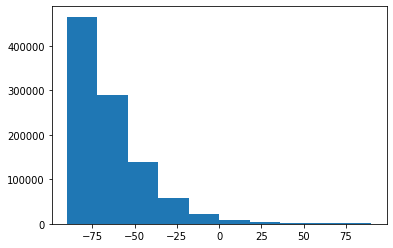

In [ ]:
plt.hist(head_angle)